
## Image classifier for the SVHN dataset


In [ ]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout ,Flatten
from tensorflow.keras import Sequential
import pandas as pd
%matplotlib inline

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.



In [ ]:
# load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

## 1. Inspect and preprocess the dataset


In [ ]:
#loading training data
X_train = train['X']
y_train = train['y']
#loading test data
X_test = test['X']
y_test = test['y']
#Converting array of shape (32,32,3,Batch) into shape (Batch,32,32,3)
X_train = np.moveaxis(X_train,-1,0)
X_test = np.moveaxis(X_test,-1,0)

In [ ]:
#One-hot encoding y labels
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

y_train_oh = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = enc.transform(y_test.reshape(-1, 1)).toarray()

In [ ]:
#Convert images to grayscale and normalize
X_train_gr = np.mean(X_train,3).reshape(73257,32,32,1)/255
X_test_gr = np.mean(X_test,3).reshape(26032, 32, 32,1)/255

In [ ]:
#Show random images
plt.figure(figsize=(10,10))

for i, (image) in enumerate(X_train_gr.take(10)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
plt.show()         

TypeError: 'numpy.float64' object is not iterable

<Figure size 720x720 with 0 Axes>

## 2. MLP neural network classifier


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
def get_mlp_model(input_shape):
    model = Sequential([
        Flatten(input_shape = input_shape, name = 'flatten_1'),
        Dense((256), activation = 'relu', kernel_initializer='he_uniform', name = 'dense_1'),
        Dense((64), activation = 'relu',  name = 'dense_2'),
        Dense((32), activation = 'relu',  name = 'dense_3'),
        Dense((16), activation = 'relu',  name = 'dense_4'),
        Dense((10), activation = 'softmax', name = 'softmax'),
    ])
    
    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy']
    )
    
    return model

In [ ]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
model_mlp = get_mlp_model(X_train_gr[0].shape)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
softmax (Dense)              (None, 10)                170       
Total params: 281,626
Trainable params: 281,626
Non-trainable params: 0
__________________________________________________

In [ ]:
checkpoint_path_best_mlp = "checkpoints_best_only_mlp/checkpoint"
checkpoint_mlp = ModelCheckpoint(filepath = checkpoint_path_best_mlp,
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch',
                                monitor = 'val_accuracy',
                                verbose = 1)

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                                  patience=3, verbose=1)

callbacks = [checkpoint_mlp, early_stopping]

history_mlp = model_mlp.fit(X_train_gr, y_train_oh, epochs=30, batch_size=None, validation_split=0.15, callbacks=callbacks, verbose = 1)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62144/62268 [============================>.] - ETA: 0s - loss: 2.2063 - accuracy: 0.2012
Epoch 00001: val_accuracy improved from -inf to 0.25644, saving model to checkpoints_best_only_mlp/checkpoint
62268/62268 [==============================] - 55s 885us/sample - loss: 2.2059 - accuracy: 0.2012 - val_loss: 2.0785 - val_accuracy: 0.2564
Epoch 2/30
62144/62268 [============================>.] - ETA: 0s - loss: 1.9996 - accuracy: 0.2934
Epoch 00002: val_accuracy improved from 0.25644 to 0.36182, saving model to checkpoints_best_only_mlp/checkpoint
62268/62268 [==============================] - 45s 716us/sample - loss: 1.9991 - accuracy: 0.2936 - val_loss: 1.8418 - val_accuracy: 0.3618
Epoch 3/30
62112/62268 [============================>.] - ETA: 0s - loss: 1.6876 - accuracy: 0.4120
Epoch 00003: val_accuracy improved from 0.36182 to 0.44108, saving model to checkpoints_best_only_mlp/checkpoint
62268/62268 [=====================

accuracy: 0.710


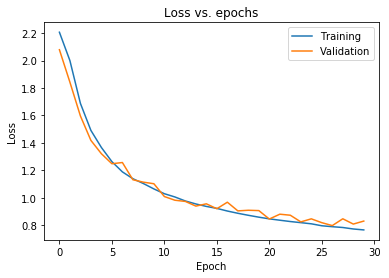

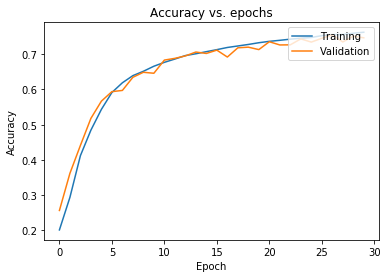

In [ ]:
get_test_accuracy(model_mlp,X_test_gr, y_test_oh)
# Plot the training and validation loss and accuracy

plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 3. CNN neural network classifier


In [ ]:
def get_cnn_model(input_shape):
    model = Sequential([
      Conv2D(kernel_size = (3,3), filters = 16, padding = 'SAME', activation = 'relu', input_shape = input_shape, name = 'conv_1', kernel_initializer='he_uniform'),
        MaxPooling2D((2,2), name = 'max_pool_1'),
        BatchNormalization(name = 'batch_norm_1'),
        Conv2D(kernel_size = (3,3), filters = 32, padding = 'SAME', activation = 'relu', name = 'conv_2',  kernel_initializer='he_uniform'),
        MaxPooling2D((2,2), name = 'max_pool_2'),
        BatchNormalization(name = 'batch_norm_2'),
        Flatten(),
        Dense(64, activation = 'relu', name = 'dense_1'),
        Dropout(0.5, name = 'dropout_1'),
        Dense(64, activation = 'relu', name = 'dense_2'),
        Dense(10,activation = 'softmax', name = 'softmax')
    ])
    
    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy']
    )
    
    return model

In [ ]:
model_cnn = get_cnn_model(X_train_gr[0].shape)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 16, 16, 16)        64        
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 8, 8, 32)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 8, 8, 32)          128       
_________________________________________________________________
flatten (Flatten)            (None, 2048)             

In [ ]:
checkpoint_path_best_cnn = "checkpoints_best_only_cnn/checkpoint"
checkpoint_cnn = ModelCheckpoint(filepath = checkpoint_path_best_cnn,
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch',
                                monitor = 'val_accuracy',
                                verbose = 1)

In [ ]:
callbacks = [checkpoint_cnn, early_stopping]
history_cnn = model_cnn.fit(X_train_gr, y_train_oh, epochs=30,validation_split=0.15, callbacks=callbacks, verbose = 1) 

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.2641 - accuracy: 0.5610
Epoch 00001: val_accuracy improved from -inf to 0.81764, saving model to checkpoints_best_only_cnn/checkpoint
62268/62268 [==============================] - 320s 5ms/sample - loss: 1.2638 - accuracy: 0.5611 - val_loss: 0.6117 - val_accuracy: 0.8176
Epoch 2/30
62240/62268 [============================>.] - ETA: 0s - loss: 0.7013 - accuracy: 0.7763
Epoch 00002: val_accuracy improved from 0.81764 to 0.84912, saving model to checkpoints_best_only_cnn/checkpoint
62268/62268 [==============================] - 305s 5ms/sample - loss: 0.7013 - accuracy: 0.7763 - val_loss: 0.5072 - val_accuracy: 0.8491
Epoch 3/30
62240/62268 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.8141
Epoch 00003: val_accuracy did not improve from 0.84912
62268/62268 [==============================] - 301s 5ms/sample - loss: 0.5938 - accuracy: 0.81

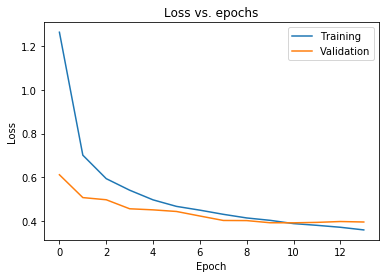

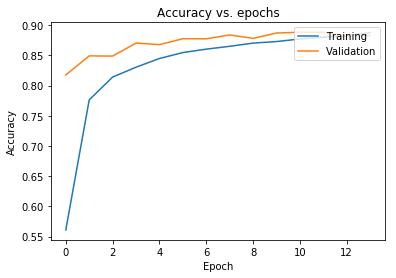

In [ ]:
# Plot the training and validation loss and accuracy

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
get_test_accuracy(model_cnn,X_test_gr, y_test_oh)

accuracy: 0.874


## 4. Get model predictions


In [ ]:
#loading model weights for mlp
model = get_mlp_model(X_train_gr[0].shape)
model.load_weights("/content/checkpoints_best_only_mlp/checkpoint")

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /content/checkpoints_best_only_mlp/checkpoint: Not found: /content/checkpoints_best_only_mlp; No such file or directory

In [ ]:
print(get_test_accuracy(model,X_test_gr, y_test_oh))

accuracy: 0.101
None


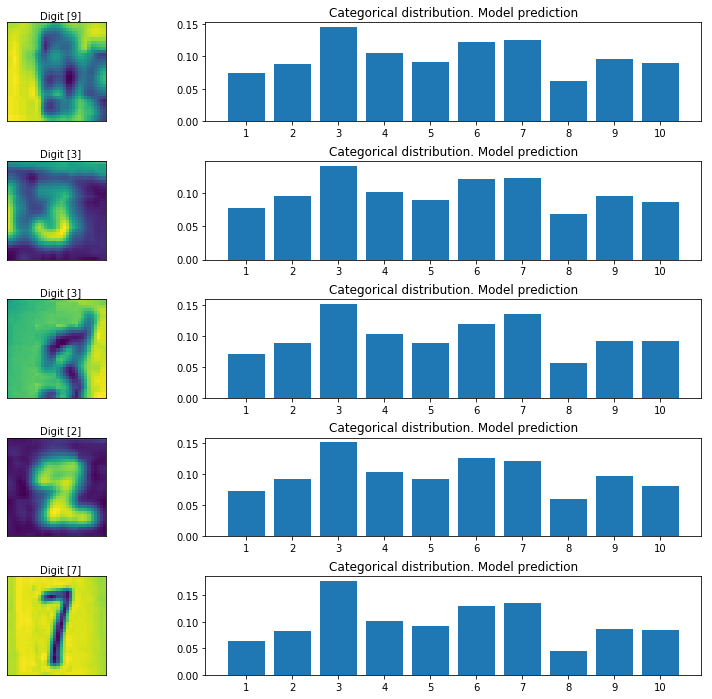

In [ ]:
num_test_images = X_test_gr.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test_gr[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

In [ ]:
#loading model weights for cnn
model = get_cnn_model(X_train_gr[0].shape)
model.load_weights("/content/checkpoints_best_only_cnn/checkpoint")

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /content/checkpoints_best_only_cnn/checkpoint: Not found: /content/checkpoints_best_only_cnn; No such file or directory

In [ ]:
print(get_test_accuracy(model,X_test_gr, y_test_oh))

accuracy: 0.109
None


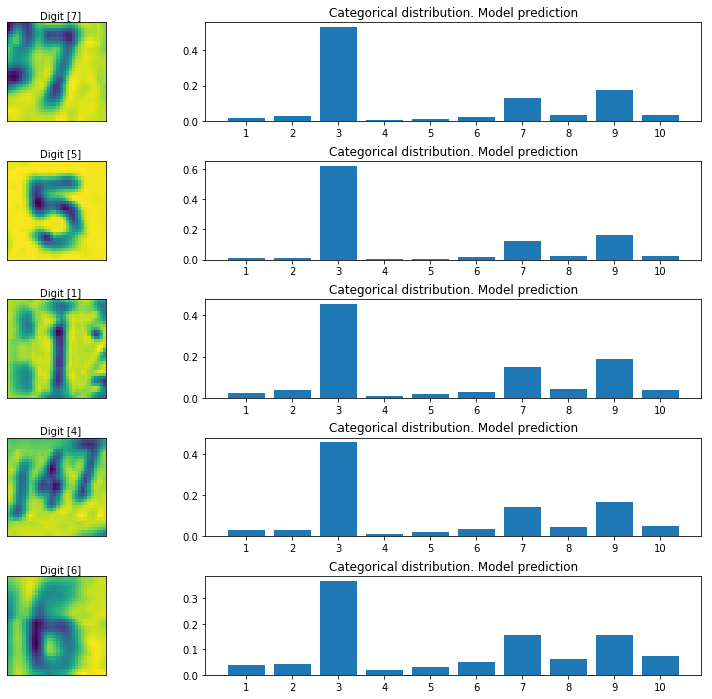

In [ ]:
num_test_images = X_test_gr.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test_gr[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()